In [4]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

# !pip install opencv-python-headless
import cv2
from matplotlib.patches import Rectangle
from typing import List, Tuple
import itertools
from copy import copy, deepcopy
import os
import shutil

import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient, BlobServiceClient
from azure.core.exceptions import ResourceExistsError


In [88]:
####################################
# Read heat-extremes dataset 1 year of data
####################################

# import heat extremes data
fn = f"Ext_max_t__Rgn_1__2015__Abv_Avg_5_K_for_4_days__CMIP6_ssp245_Avg_yrs_1950_79.nc"
ds = xr.open_mfdataset(fn)

print(ds.attrs['Number of continuous days to be considered extreme'], "days")
print(ds.attrs['threshold'], "K above")

4 days
5 K above


In [100]:
####################################
# Bounding-boxes algorithm 
####################################

"""
This is the earlier version of the "Contours" algorithm.
Bounding-boxes algorithm to find the extend of the heat events and
produce visualizations. It uses the the heat events y/n dataset 
which was (supposed to be pre-) produced by the "Heatwave Analysis" algorithm. 
"""

def bounding_boxes(arr2d: np.array) -> List[tuple]:
    
    H = arr2d.astype(np.uint8)
    ret, thresh = cv2.threshold(H, 0, 1, 0, cv2.THRESH_BINARY)
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(c) for c in contours]
    return boxes

def isoverlap(box1:tuple, box2:tuple) -> bool:
    """Return True if two windows overlap"""
    x1,y1,w1,h1 = box1
    x2,y2,w2,h2 = box2
    return not (x2>x1+w1 or x2+w2<x1 or y2>y1+h1 or y2+h2<y1)

def outer(box1:tuple, box2:tuple) -> tuple:
    """Fuse two windows into one, parent window."""
    x1,y1,w1,h1 = box1
    x2,y2,w2,h2 = box2
    x = min(x1,x2)
    y = min(y1,y2)
    w = max(x1+w1,x2+w2)-x
    h = max(y1+h1,y2+h2)-y
    return (x, y, w, h)

def istiny(box:tuple, min_area:int) -> bool:
    x,y,w,h = box
    return w*h <= min_area

def filter_tiny_ones(boxes:List[tuple]) -> List[tuple]:
    return [c for c in boxes if not istiny(c, 10)]

def collapse(boxes:List[tuple]) -> List[tuple]:
    
    for box1, box2 in itertools.combinations(boxes, 2):
        if isoverlap(box1,box2):
            boxes.remove(box1)
            boxes.remove(box2)
            boxes.append(outer(box1,box2))
            return collapse(boxes) # recursion

    boxes.sort(key=lambda _:_[0])
    return boxes

def array2boxes(arr2d:np.array) -> List[tuple]:
    """Pipeline. Takes a time-slice (2D array) and returns the boxes."""
    boxes = bounding_boxes(arr2d)
    boxes = filter_tiny_ones(boxes)
    boxes = collapse(boxes)
    return boxes

def groupby_heat_events(arr3d:np.array) -> pd.DataFrame:
    """Concat consequtive overlappoing boxes in 3rd (time) axis"""
    rows = []
    num_days = arr3d.shape[0]

    for i in range(num_days):
        arr2d = arr3d[i,:,:]
        boxes = array2boxes(arr2d)
        rows += [dict(time=i, boxes=boxes)]
        
    df = pd.DataFrame(rows)
    df['hasEvent'] = df['boxes'].apply(lambda x: len(x)) > 0
    df['label'] = df['hasEvent'].diff().ne(False).cumsum()

    dff = df[df['hasEvent']]

    dfg = dff.groupby('label').agg({
        'time':[np.min,np.max], 
        'boxes':lambda _: collapse(np.sum(_))
    }).reset_index()
    
    dfg.columns = ['label', 'i1', 'i2', 'boxes']
    dfg = dfg.drop('label', axis=1)
    
    return dfg

def box_events(ds:xr.Dataset, summer_only=True) -> pd.DataFrame:
    
    # accept 1-year data only
    n_days = len(ds_heat['time'])
    if n_days != 365:
        err = f"dimension mismatch: expected 365 but got {n_days}"
        raise ValueError(err)
    
    # subset for summer months
    da = ds['extreme_yn']
    
    if summer_only:
        sm = [5, 6, 7, 8, 9]
        arr3d = da.loc[da['time.month'].isin(sm)].values
    else:
        arr3d = da.values
    
    # find bounding boxes
    df = groupby_heat_events(arr3d)
    
    # add dates to the df
    dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))
    df = df.assign(d1=dr[df['i1']], d2=dr[df['i2']])
    
    return df

df_boxes = box_events(ds)
df_boxes

,i1,i2,boxes,d1,d2
0,0,152,"[(14, 0, 579, 279), (597, 200, 14, 9), (598, 2...",2015-01-01,2015-06-02


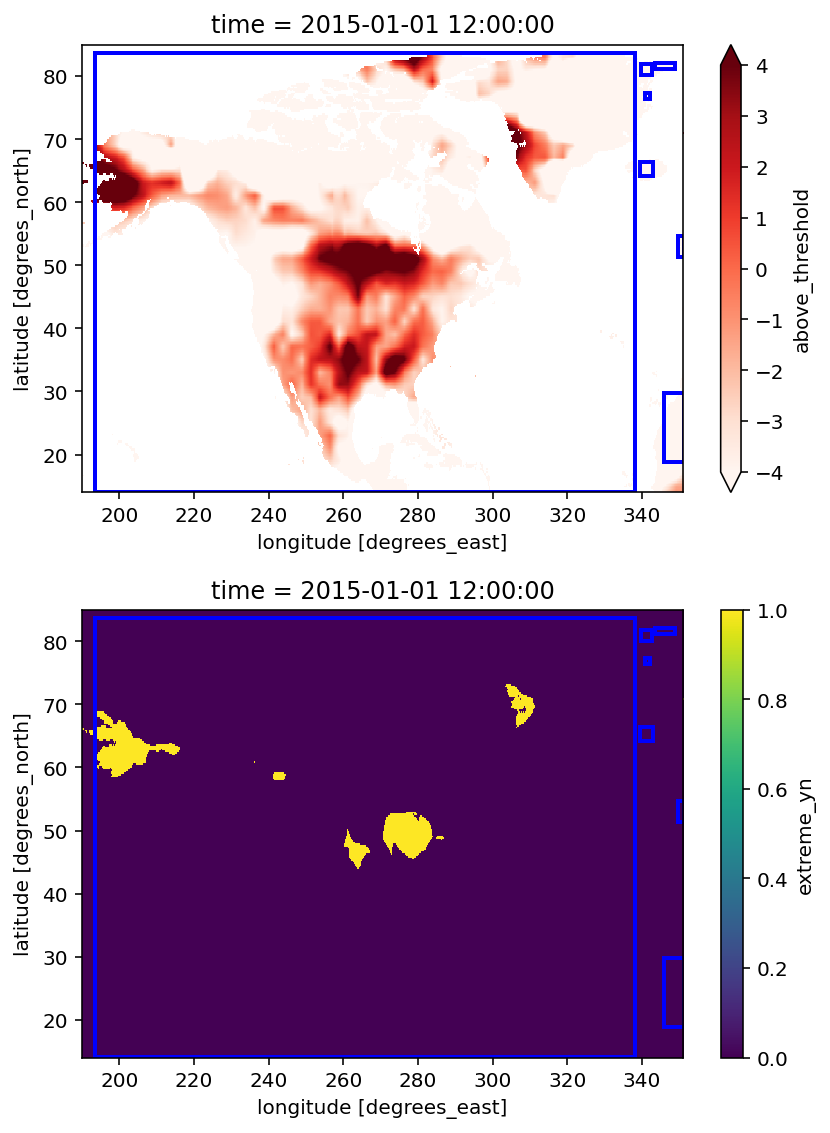

In [120]:
####################################
# Inspection: generate images of boxed heat events for display on notebook
####################################

dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))
lat_min, lat_max = ds['lat'].min(), ds['lat'].max()
lon_min, lon_max = ds['lon'].min(), ds['lon'].max()

for ev, (i1, i2) in df_boxes[['i1','i2']].iterrows():
    
    for i, idx in enumerate(range(i1,i2+1)):
        
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
        
        day = dr[idx].strftime("%Y-%m-%d")
        tasmax = ds['tasmax'].sel(time=day)
        tdiff = ds['above_threshold'].sel(time=day)
        extreme = ds['extreme_yn'].sel(time=day)
        
        im1 = tdiff.squeeze().plot.imshow(ax=ax1, cmap='Reds', vmin=-4, vmax=4)
        im2 = extreme.squeeze().plot.imshow(ax=ax2)
    
        # add bounding boxes
        boxes = df_boxes['boxes'].iloc[ev]
        for b in boxes:
            x,y,w,h = b
            x = float(tdiff.coords['lon'][x])
            y = float(tdiff.coords['lat'][y])
            _, leny, lenx = tdiff.shape

            w = w * (lon_max-lon_min) / lenx
            h = h * (lat_max-lat_min) / leny 

            rect = Rectangle((x, y), w, h, color='b', fill=False, linewidth=2)
            ax1.add_patch(rect)
            
            rect = Rectangle((x, y), w, h, color='b', fill=False, linewidth=2)
            ax2.add_patch(rect)

        fig.tight_layout()
        
        break

In [ ]:
####################################
# Generate image with bounding-box and upload to Azure
####################################

for year in range(1970,1980):

    dr = pd.date_range(start=f'1/1/{year}', periods=365, freq='D').date
    arr3d = np.load(f'Koray/CMIP5_flagged/arr_heat3d-{year}.npy') # must be ready
    df_events = groupby_heat_events(arr3d)

    for ev, (i1, i2) in df_events[['i1','i2']].iterrows():
        # to write the image to disk
        folder_name = f"{year}-event{str(ev).zfill(2)}"
        folder_path = f"Koray/CMIP5_images/{folder_name}"
        if not os.path.exists(folder_path):
            os.mkdir(folder_path)
        
        # loop through heat events, some are 3 days long, some are 20
        for i, idx in enumerate(range(i1,i2+1)):

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

            day = dr[idx].strftime("%Y-%m-%d")
            tasmax = ds['tasmax'].sel(time=day, **area)
            tavg3d = ds_avg['tasmaxavg'].sel(day=idx, **area)
            tdiff = tasmax - tavg3d

            im1 = tdiff.squeeze().plot.imshow(ax=ax1, cmap='Reds', vmin=-4, vmax=4)
            im2 = (tasmax-273.15).squeeze().plot.imshow(ax=ax2, vmin=5, vmax=50)

            # add bounding boxes
            boxes = df_events['boxes'].iloc[ev]
            for b in boxes:
                x,y,w,h = b
                x = float(tdiff.coords['lon'][x])
                y = float(tdiff.coords['lat'][y])
                _, leny, lenx = tdiff.shape

                w = w * (lon_max-lon_min) / lenx
                h = h * (lat_max-lat_min) / leny 

                rect = Rectangle((x, y), w, h, color='b', fill=False, linewidth=2)
                ax1.add_patch(rect)
                rect = Rectangle((x, y), w, h, color='b', fill=False, linewidth=2)
                ax2.add_patch(rect)

            fig.tight_layout()

            # save each image, each event has multiple images, one per event day.
            filename = f"{folder_path}/{day}.png"
            fig.savefig(filename, dpi=fig.dpi)
            plt.close(fig)

            # upload image to azure
            sas_url = f"{url_prefix}/{blob_folder}/{filename}?{sas_token}"
            blob_client = BlobClient.from_blob_url(sas_url)
            with open(filename, "rb") as f:
                try:
                    blob_client.upload_blob(f)
                except ResourceExistsError:
                    pass
    
        # flush VM disk space
        shutil.rmtree(folder_path)
